# Chemical space comparison across multiple data resources
This notebook has the distribution of patented compounds across three major chemical resources namely PubChem, ChEMBL, and DrugBank data resources

# Import Modules

In [1]:
import os
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import pylab
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
from itertools import chain

In [2]:
mpl.rcParams['figure.dpi'] = 400
sns.set(context='paper', style='white') 

# Add path constants

In [3]:
FIG_DIR = 'data/figures'

In [4]:
os.makedirs(FIG_DIR, exist_ok=True)

# Load data file

In [5]:
drugbank_df = pd.read_csv('data/drugbank_approved_structure_links.csv.zip')
drugbank_df.head(2) #drugbank

,DrugBank ID,Name,CAS Number,Drug Groups,InChIKey,InChI,SMILES,Formula,KEGG Compound ID,KEGG Drug ID,PubChem Compound ID,PubChem Substance ID,ChEBI ID,ChEMBL ID,HET ID,ChemSpider ID,BindingDB ID
0,DB00006,Bivalirudin,128270-60-0,approved; investigational,OIRCOABEOLEUMC-GEJPAHFPSA-N,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,C98H138N24O33,NaN,D03136,16129704.0,46507415.0,59173.0,CHEMBL2103749,NaN,10482069.0,50248103.0
1,DB00007,Leuprolide,53714-56-0,approved; investigational,GFIJNRVAKGFPGQ-LIJARHBVSA-N,InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...,C59H84N16O12,C07612,D08113,NaN,46507635.0,6427.0,CHEMBL1201199,NaN,571356.0,50369395.0


In [6]:
cid_chembl_df = pd.read_csv('data/PUBCHEM_CID_CHEMBL_ID.tsv', sep='\t')
cid_chembl_df.head(2)

,SCHEMBL_ID,InChIKey,PUBCHEM_CID,CHEMBL_ID
0,SCHEMBL4,FAKRSMQSSFJEIM-RQJHMYQMSA-N,44093.0,CHEMBL1560
1,SCHEMBL9,OYFJQPXVCSSHAI-QFPUQLAESA-N,5388961.0,CHEMBL1200659


In [7]:
drugbnk_approved_df = drugbank_df[['InChIKey', 'DrugBank ID' ]]
drugbnk_approved_df.head(2)

,InChIKey,DrugBank ID
0,OIRCOABEOLEUMC-GEJPAHFPSA-N,DB00006
1,GFIJNRVAKGFPGQ-LIJARHBVSA-N,DB00007


In [8]:
merged_df = pd.merge(cid_chembl_df, drugbnk_approved_df, how="left", on=["InChIKey"])
merged_df.head(2)

,SCHEMBL_ID,InChIKey,PUBCHEM_CID,CHEMBL_ID,DrugBank ID
0,SCHEMBL4,FAKRSMQSSFJEIM-RQJHMYQMSA-N,44093.0,CHEMBL1560,DB01197
1,SCHEMBL9,OYFJQPXVCSSHAI-QFPUQLAESA-N,5388961.0,CHEMBL1200659,NaN


# Lists for Venn diagram

In [9]:
#SureChEMBL 

surechembl_cpds = merged_df['InChIKey'].tolist() 
len(surechembl_cpds) 

17416

In [10]:
#PubChem

Pubchem_df = merged_df[['InChIKey', 'PUBCHEM_CID']]
Pubchem_df.dropna(subset=['PUBCHEM_CID'], inplace=True)
pubchem_cpds = Pubchem_df['InChIKey'].tolist()
len(pubchem_cpds) 

C:\Users\Shantanu Shetty\AppData\Local\Temp\ipykernel_14128\2499966238.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pubchem_df.dropna(subset=['PUBCHEM_CID'], inplace=True)


16929

In [11]:
#ChEMBL

ChEMBL_df = merged_df[['InChIKey', 'CHEMBL_ID']]
ChEMBL_df.dropna(subset=['CHEMBL_ID'], inplace=True)
chembl_cpds = ChEMBL_df['InChIKey'].tolist()
len(chembl_cpds)

C:\Users\Shantanu Shetty\AppData\Local\Temp\ipykernel_14128\3616846674.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ChEMBL_df.dropna(subset=['CHEMBL_ID'], inplace=True)


6103

In [12]:
#DrugBank

DrugBank_df = merged_df[['InChIKey', 'DrugBank ID']]
DrugBank_df.dropna(subset=['DrugBank ID'], inplace=True)
drugbank_cpds = DrugBank_df['InChIKey'].tolist()
len(drugbank_cpds)

C:\Users\Shantanu Shetty\AppData\Local\Temp\ipykernel_14128\1943018234.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DrugBank_df.dropna(subset=['DrugBank ID'], inplace=True)


1256

# Visualisation

In [13]:
alignment = {'horizontalalignment':'center', 'verticalalignment':'baseline'}
colors = ['r', 'b', 'g', 'c']

In [14]:
def venn(data, names=None, fill="number", show_names=True, show_plot=True, **kwds):
    
    """method to create venn diagram"""  
    
    venn4(data, names, fill, show_names, show_plot, **kwds)

In [15]:
def get_labels(data, fill="number"):
    
    """method to get labels for venn diagram"""
    
    N = len(data)

    sets_data = [set(data[i]) for i in range(N)]  
    s_all = set(chain(*data))                             

    set_collections = {}
    for n in range(1, 2**N):
        key = bin(n).split('0b')[-1].zfill(N)
        value = s_all
        sets_for_intersection = [sets_data[i] for i in range(N) if  key[i] == '1']
        sets_for_difference = [sets_data[i] for i in range(N) if  key[i] == '0']
        for s in sets_for_intersection:
            value = value & s
        for s in sets_for_difference:
            value = value - s
        set_collections[key] = value

    if fill == "number":
        labels = {k: len(set_collections[k]) for k in set_collections}
    elif fill == "logic":
        labels = {k: k for k in set_collections}
    elif fill == "both":
        labels = {k: ("%s: %d" % (k, len(set_collections[k]))) for k in set_collections}
    else:  
        raise Exception("invalid value for fill")

    return labels

In [16]:
def venn4(data=None, names=None, fill="number", show_names=True, show_plot=True, **kwds):
    
    """formatting venn diagram text, name and orientation"""

    if (data is None) or len(data) != 4:
        raise Exception("length of data should be 4!")
    if (names is None) or (len(names) != 4):
        names = ("set 1", "set 2", "set 3", "set 4")

    labels = get_labels(data, fill=fill)

    if 'figsize' in kwds and len(kwds['figsize']) == 2:
        figsize = kwds['figsize']
    else: 
        figsize = (10, 10)

    fig = pylab.figure(figsize=figsize)  
    ax = fig.gca()
    patches = []
    width, height = 170, 110  
    patches.append(Ellipse((170, 170), width, height, -45, color=colors[0], alpha=0.5))
    patches.append(Ellipse((200, 200), width, height, -45, color=colors[1], alpha=0.5))
    patches.append(Ellipse((200, 200), width, height, -135, color=colors[2], alpha=0.5))
    patches.append(Ellipse((230, 170), width, height, -135, color=colors[3], alpha=0.5))
    for e in patches:
        ax.add_patch(e)
    ax.set_xlim(80, 320); ax.set_ylim(80, 320)
    ax.set_xticks([]); ax.set_yticks([]);
    ax.set_aspect("equal")
    for spine in fig.gca().spines.values():
        spine.set_visible(False)


    # 1
    pylab.text(120, 200, labels['1000'], **alignment, fontsize=18)
    pylab.text(280, 200, labels['0100'], **alignment, fontsize=18)
    pylab.text(155, 250, labels['0010'], **alignment, fontsize=18)
    pylab.text(245, 250, labels['0001'], **alignment, fontsize=18)
    # 2
    pylab.text(200, 115, labels['1100'], **alignment, fontsize=18)
    pylab.text(140, 225, labels['1010'], **alignment, fontsize=18)
    pylab.text(145, 155, labels['1001'], **alignment, fontsize=18)
    pylab.text(255, 155, labels['0110'], **alignment, fontsize=18)
    pylab.text(260, 225, labels['0101'], **alignment, fontsize=18)
    pylab.text(200, 240, labels['0011'], **alignment, fontsize=18)
    # 3
    pylab.text(235, 205, labels['0111'], **alignment, fontsize=18)
    pylab.text(165, 205, labels['1011'], **alignment, fontsize=18)
    pylab.text(225, 135, labels['1101'], **alignment, fontsize=18)
    pylab.text(175, 135, labels['1110'], **alignment, fontsize=18)
    # 4
    pylab.text(200, 175, labels['1111'], **alignment, fontsize=18)

    if show_names:
        pylab.text(110, 110, names[0], fontsize=18, **alignment)
        pylab.text(290, 110, names[1], fontsize=18, **alignment)
        pylab.text(270, 275, names[2], fontsize=18, **alignment)
        pylab.text(130, 275, names[3], fontsize=18, **alignment)


    if show_plot:
        plt.savefig(f'{FIG_DIR}/figure_1.png',dpi=400)
        pylab.show()

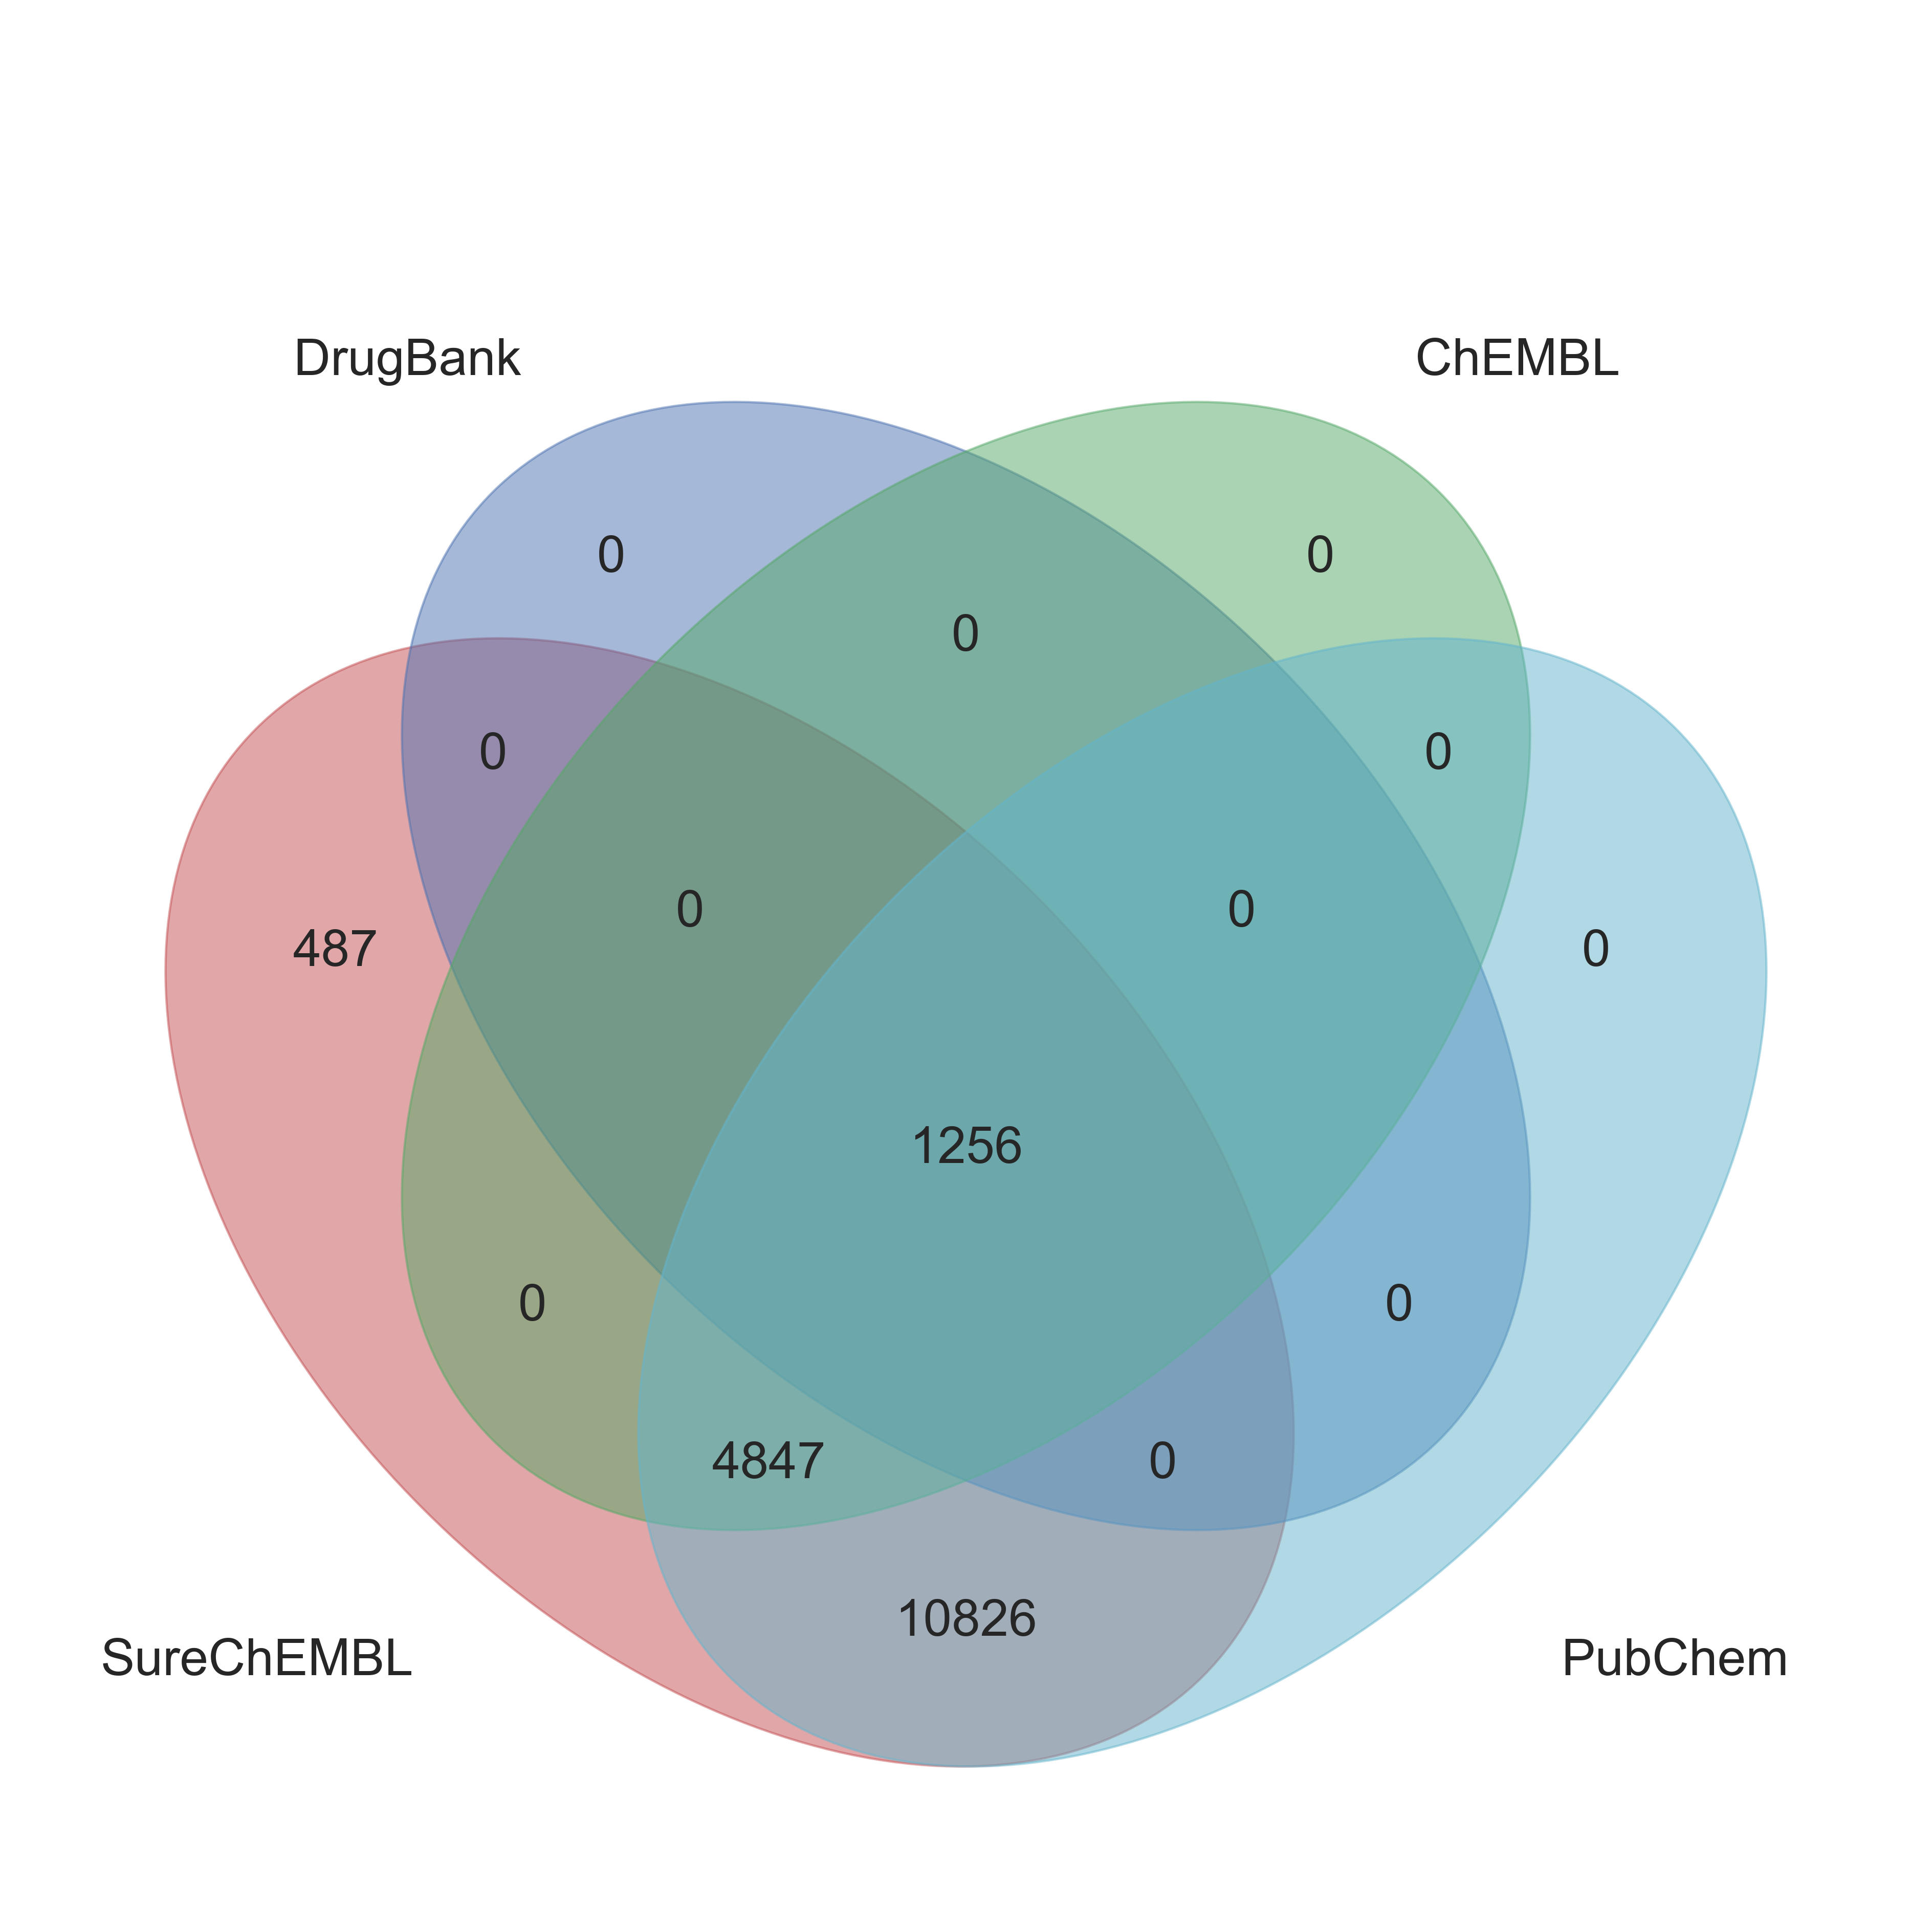

In [17]:
venn(
    [range(len(surechembl_cpds)), range(len(pubchem_cpds)), range(len(chembl_cpds)), range(len(drugbank_cpds))], 
    ["SureChEMBL", "PubChem", "ChEMBL", "DrugBank "], 
    figsize=(12,12)
)